In [ ]:
!pip install transformers
!pip install seqeval

In [63]:
import pandas as pd
from collections import defaultdict, Counter
import os
from itertools import chain
import sklearn.preprocessing as skp
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
###importnat###
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score, classification_report

In [65]:
%%time
dataset = from_dir('data')

CPU times: user 6.12 s, sys: 116 ms, total: 6.24 s
Wall time: 6.24 s


In [66]:
dataset.sample(2)

,predictors,labels,file
7028,[Fischermeier],[B-RR],bag
5414,"[bb, ), Die, gleichheitsrechtlichen, Anforderu...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",bverwg


In [67]:
tag = []
for i in dataset['labels']:
  for j in i:
    tag.append(j)
# Create a dictionary containing the tags and the corresponding index
tags2vals = list(set(tag))
print(tags2vals)
tag2idx = {t: i for i, t in enumerate(tags2vals)}
print(tag2idx)

['I-ST', 'B-UN', 'I-UN', 'I-LIT', 'I-VS', 'B-RS', 'B-RR', 'I-EUN', 'B-GS', 'B-GRT', 'I-MRK', 'O', 'B-VT', 'B-ORG', 'I-PER', 'I-LDS', 'I-AN', 'B-VS', 'I-VO', 'B-INN', 'B-AN', 'B-ST', 'B-LD', 'I-LD', 'B-EUN', 'I-ORG', 'B-LDS', 'I-RR', 'I-INN', 'I-GS', 'I-VT', 'B-MRK', 'I-STR', 'B-STR', 'B-VO', 'I-GRT', 'B-LIT', 'I-RS', 'B-PER']
{'I-ST': 0, 'B-UN': 1, 'I-UN': 2, 'I-LIT': 3, 'I-VS': 4, 'B-RS': 5, 'B-RR': 6, 'I-EUN': 7, 'B-GS': 8, 'B-GRT': 9, 'I-MRK': 10, 'O': 11, 'B-VT': 12, 'B-ORG': 13, 'I-PER': 14, 'I-LDS': 15, 'I-AN': 16, 'B-VS': 17, 'I-VO': 18, 'B-INN': 19, 'B-AN': 20, 'B-ST': 21, 'B-LD': 22, 'I-LD': 23, 'B-EUN': 24, 'I-ORG': 25, 'B-LDS': 26, 'I-RR': 27, 'I-INN': 28, 'I-GS': 29, 'I-VT': 30, 'B-MRK': 31, 'I-STR': 32, 'B-STR': 33, 'B-VO': 34, 'I-GRT': 35, 'B-LIT': 36, 'I-RS': 37, 'B-PER': 38}


In [68]:
# sequence length: 100 tokens
MAX_LEN = 100
# batch size: 32
bs = 32

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [70]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [71]:
#define a tokenizer with pretrained modell 'bert-base-cased' 
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [72]:
# Build a function, that tokenize all sentences in tokens and all tokens in subword tokens
def bert_tokenizer(sentence, labels):
  tokenizer_final = []
  labels_final = []

  for token, label in zip(sentence, labels):
    # Use bert tokeniser
    sub_token = tokenizer.tokenize(token)
    subtoken_len = len(sub_token)
    tokenizer_final.extend(sub_token)
    labels_final.extend([label] * subtoken_len)

  return tokenizer_final, labels_final

In [73]:
tokenizerbert = [bert_tokenizer(sent, label) for sent, label in zip(dataset['predictors'], dataset['labels'])]

In [74]:
tokenized_texts = [token_label[0] for token_label in tokenizerbert]
labels = [token_label[1] for token_label in tokenizerbert]

In [75]:
print(tokenized_texts[10])
print(labels[10])

['2', '.', 'Die', 'En', '##ts', '##che', '##id', '##ung', 'des', 'Land', '##ger', '##ich', '##ts', ',', 'von', 'der', 'Un', '##ter', '##bri', '##ng', '##ung', 'des', 'Ang', '##ek', '##lag', '##ten', 'in', 'e', '##iner', 'En', '##tz', '##ie', '##hun', '##gs', '##ans', '##tal', '##t', 'g', '##em', '##ä', '##ß', '§', '64', 'St', '##GB', 'a', '##b', '##zu', '##se', '##hen', ',', 'beg', '##eg', '##net', 'hi', '##nge', '##gen', 'du', '##rch', '##g', '##re', '##ife', '##nden', 're', '##cht', '##liche', '##n', 'Bed', '##en', '##ken', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [76]:
# Convert input text to indices
predictors2idx = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [77]:
print(predictors2idx)

[[  122   119 27758 ...     0     0     0]
 [  170   114 26410 ...     0     0     0]
 [  171   114 13280 ... 18075 16205  8336]
 ...
 [  142  1116  1110 ...     0     0     0]
 [  123   119 23922 ...     0     0     0]
 [27758  1116  1874 ...     0     0     0]]


In [78]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [79]:
print(tags[10])

[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  8 29 29 29 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11]


In [80]:
# Create an attention mask to ignore the padded elements in the sequences
attention_mask = [[float(i != 0.0) for i in ii] for ii in predictors2idx]

In [81]:
print(attention_mask[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [82]:
# Split the dataset
# 20% for validation
X_train, X_test, Y_train, Y_test = train_test_split(predictors2idx, tags,random_state=1, test_size=0.2)
M_train, M_test, _, _ = train_test_split(attention_mask, predictors2idx,random_state=1, test_size=0.2)

In [83]:
# Convert the dataset to torch tensors
train_feat = torch.tensor(X_train)
test_feat = torch.tensor(X_test)
train_labels = torch.tensor(Y_train)
test_labels = torch.tensor(Y_test)
train_mask = torch.tensor(M_train)
test_mask = torch.tensor(M_test)

In [84]:
print(train_feat.shape)
print(test_feat.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_mask.shape)
print(test_mask.shape)

torch.Size([53378, 100])
torch.Size([13345, 100])
torch.Size([53378, 100])
torch.Size([13345, 100])
torch.Size([53378, 100])
torch.Size([13345, 100])


In [85]:
# Define the dataloaders
# Shuffle the data at training time with the RandomSampler
train_data = TensorDataset(train_feat, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Pass the data at the test time sequentially with the SequentialSampler
test_data = TensorDataset(test_feat, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [86]:
# Build the model
# Use the BertForTokenClassification that wraps BertModel and adds token-level classifier on top of the BertModel
# Load the pretrained 'bert-base-cased' model and provide the number of possible labels
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [87]:
model.cuda();

In [88]:
# Define a fine-tuning process with adding some weight_decay as regularization to the main weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
# Define an AdamW optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [89]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps
total_steps = len(train_dataloader) * epochs
# Define a scheduler to linearly reduce the learning rate throughout the epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [90]:
loss_values, validation_loss_values = [], []
validation_accuracy = []
classification_report_eval = []

for _ in trange(epochs, desc="Epoch"):
  # ========================================
  #               Training
  # ========================================    
  model.train()
  total_loss = 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    model.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    loss.backward()
    total_loss += loss.item()
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  print("Average train loss: {}".format(avg_train_loss))
  loss_values.append(avg_train_loss)

  # ========================================
  #               Validation
  # ========================================
  model.eval()
  predictions = []
  true_labels = []
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = outputs[1].detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    eval_loss += outputs[0].mean().item()
    nb_eval_steps += 1

  pred_tags = [[tags2vals[p_i] for p_i in p] for p in predictions]
  valid_tags = [[tags2vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
  eval_loss_final = eval_loss/nb_eval_steps
  print("Validation loss: {}".format(eval_loss_final))
  validation_loss_values.append(eval_loss_final)
  valid_accur = accuracy_score(valid_tags,pred_tags)
  print("Validation Accuracy: {}".format(valid_accur))
  validation_accuracy.append(valid_accur)
  class_report = classification_report(valid_tags,pred_tags)
  print("\nClassification-Report:\n", class_report)
  classification_report_eval.append(class_report)
  print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.10097842163650374
Validation loss: 0.03807995592048458
Validation Accuracy: 0.9650843012364181


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Epoch:  33%|███▎      | 1/3 [18:09<36:19, 1089.75s/it]


Classification-Report:
               precision    recall  f1-score   support

          AN       0.00      0.00      0.00        41
         EUN       0.59      0.71      0.65       705
         GRT       0.73      0.97      0.83      3477
          GS       0.56      0.95      0.71      4967
         INN       0.46      0.88      0.60      1897
          LD       0.68      0.81      0.74      1022
         LDS       0.00      0.00      0.00        65
         LIT       0.70      0.84      0.77       873
         MRK       0.47      0.16      0.24       119
         ORG       0.37      0.52      0.43       678
         PER       0.33      0.73      0.46       539
          RR       0.03      0.93      0.07       789
          RS       0.77      0.94      0.84      4524
          ST       0.54      0.33      0.41       228
         STR       0.23      0.05      0.08        58
          UN       0.35      0.68      0.46       450
          VO       0.44      0.71      0.54       294
  


Epoch:  67%|██████▋   | 2/3 [36:22<18:10, 1090.78s/it]


Classification-Report:
               precision    recall  f1-score   support

          AN       0.75      0.07      0.13        41
         EUN       0.62      0.79      0.70       705
         GRT       0.71      0.98      0.83      3477
          GS       0.57      0.95      0.71      4967
         INN       0.56      0.92      0.70      1897
          LD       0.66      0.95      0.78      1022
         LDS       0.00      0.00      0.00        65
         LIT       0.59      0.90      0.71       873
         MRK       0.41      0.34      0.37       119
         ORG       0.51      0.71      0.60       678
         PER       0.51      0.80      0.63       539
          RR       0.04      0.91      0.07       789
          RS       0.78      0.95      0.85      4524
          ST       0.49      0.62      0.55       228
         STR       0.42      0.47      0.44        58
          UN       0.53      0.83      0.65       450
          VO       0.60      0.80      0.69       294
  


Epoch: 100%|██████████| 3/3 [54:55<00:00, 1098.50s/it]


Classification-Report:
               precision    recall  f1-score   support

          AN       0.73      0.27      0.39        41
         EUN       0.66      0.86      0.74       705
         GRT       0.72      0.99      0.83      3477
          GS       0.59      0.97      0.73      4967
         INN       0.60      0.92      0.73      1897
          LD       0.68      0.96      0.80      1022
         LDS       0.20      0.06      0.09        65
         LIT       0.74      0.91      0.81       873
         MRK       0.31      0.39      0.35       119
         ORG       0.49      0.83      0.62       678
         PER       0.51      0.85      0.64       539
          RR       0.04      0.92      0.07       789
          RS       0.79      0.95      0.86      4524
          ST       0.47      0.67      0.55       228
         STR       0.49      0.60      0.54        58
          UN       0.51      0.86      0.64       450
          VO       0.62      0.86      0.72       294
  

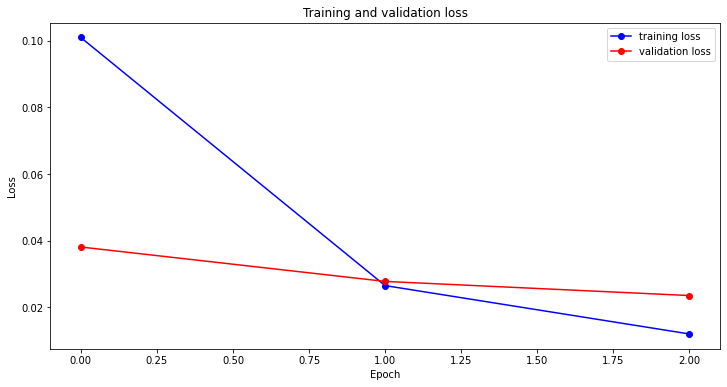

In [91]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o', label='training loss')
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

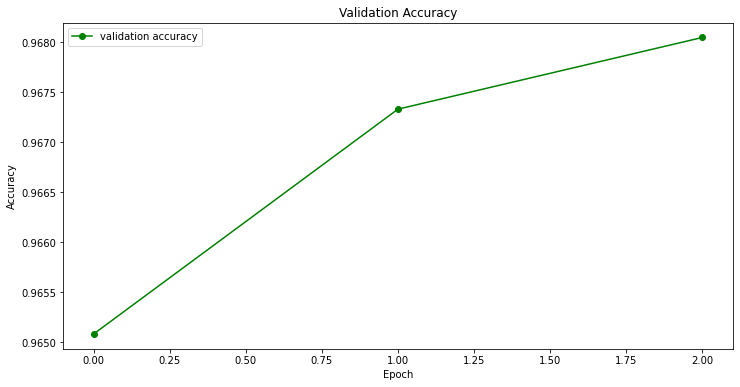

In [92]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(validation_accuracy, 'g-o', label='validation accuracy')

plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [224]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=True, cmap=plt.cm.RdPu):

  lines = cr.split('\n')
  classes = []
  plotMat = []
  for line in lines[2 : (len(lines)-5)]:
    t = line.split()
    classes.append(t[0])
    v = [float(x) for x in t[1: len(t)-1]]
    plotMat.append(v)

  if with_avg_total:
    for line in lines[len(lines)-4 : len(lines)-1]:
      aveTotal = line.split()
      classes.append(' '.join(aveTotal[:2]))
      vAveTotal = [float(x) for x in aveTotal[2:len(aveTotal) - 1]]
      plotMat.append(vAveTotal)

  plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
  plt.gcf().set_size_inches(8, 8)
  plt.title(title)
  plt.colorbar()
  x_tick_marks = np.arange(3)
  y_tick_marks = np.arange(len(classes))
  plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
  plt.yticks(y_tick_marks, classes)
  plt.tight_layout()
  plt.ylabel('Classes')
  plt.xlabel('Measures')

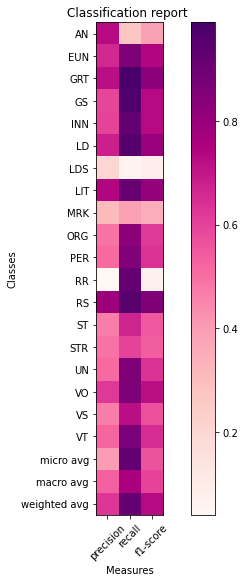

In [229]:
plot_classification_report(classification_report_eval[2])

In [46]:
model_save_name = 'bert.pt' 
torch.save(model, model_save_name)